#Импорт всех необходимых библиотек

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-n5gubrit
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-n5gubrit
     |████████████████████████████████| 47.8 MB 1.4 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=28591bff4a44a0ccf8805dcf24efb7a3e1fbe8d98f308ac189fc84acbc864c51
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qmohdt0/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
import cv2
import random
import torch
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import os
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensor, ToTensorV2
import re
import xml.etree.ElementTree as ET
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# Скачаем датасет

[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

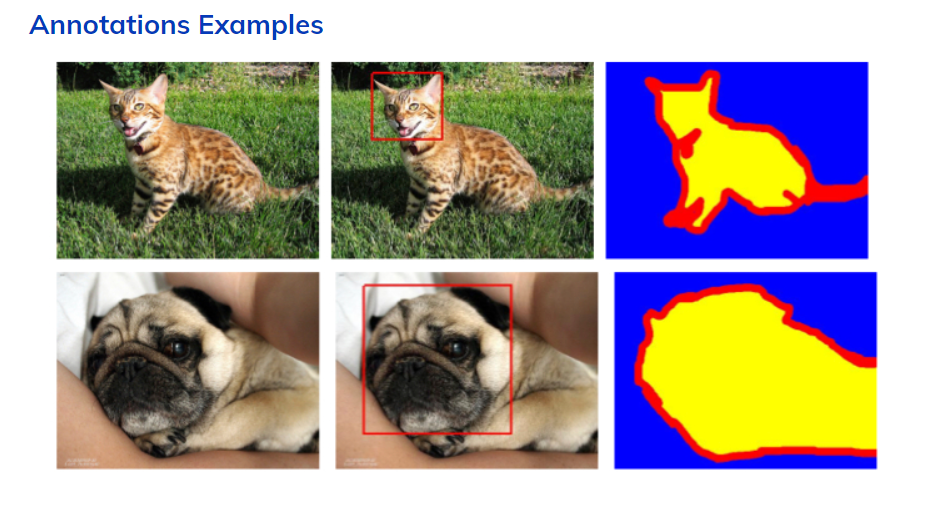

In [ ]:
!mkdir dataset

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  13.4M      0  0:00:56  0:00:56 --:--:-- 14.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  3931k      0  0:00:04  0:00:04 --:--:-- 4037k


In [ ]:
!tar -xf images.tar.gz -C dataset/
!tar -xf annotations.tar.gz -C dataset/

# Разделим датасет на подвыборки

Некоторые файлы в наборе данных повреждены, поэтому мы будем использовать только те файлы изображений, которые OpenCV может правильно загрузить.

In [ ]:
dataset_directory = 'dataset'
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

Разметка датасета хранится в файлах XML, потому что она имеет формат PASCAL VOC. В данном датасете размеченно 3686 фотографиий. Соберем датафрейм, в котором для размеченных изображений будут храниться bbox

In [ ]:
annot_dir = Path("dataset/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]
ann_pths = []
print("[INFO] Creating the paths to the annotations ...")
for a in tqdm(annots):
    for i in correct_images_filenames:
        i_pth = i.split(os.path.sep)[-1].split(".")[0]
        a_pth = a.split(os.path.sep)[-1].split(".")[0]
        if i_pth == a_pth : ann_pths.append(a)
print("Annotation files found : ", len(ann_pths))

[INFO] Creating the paths to the annotations ...


100%|██████████| 3686/3686 [00:26<00:00, 139.01it/s]

Annotation files found :  3686


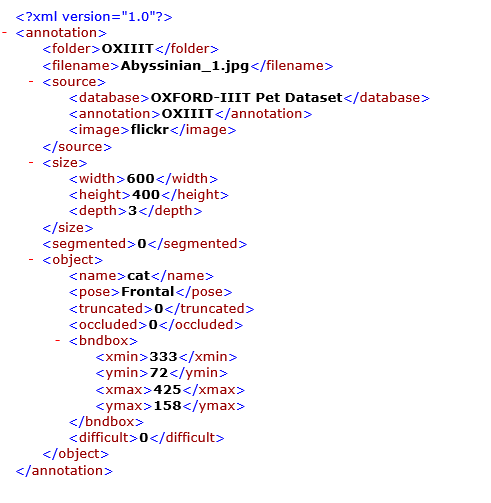

In [ ]:
def xml_to_csv(pths:list) -> pd.DataFrame:
    """Extracts the filenames and the bboxes from the xml_list"""
    print("[INFO] Gathering the filenames and bboxes")
    xml_list = []
    for xml_file in tqdm(pths):
      tree=ET.parse(xml_file)
      root =tree.getroot()
      for m in root.findall("object"):
          try:
            value=(
                str(root.find("filename").text),
                float(m[4][0].text),
                float(m[4][1].text),
                float(m[4][2].text),
                float(m[4][3].text),
           )
            xml_list.append(value)
          except exepsion as e: print(e)
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [ ]:
df = xml_to_csv(ann_pths)

[INFO] Gathering the filenames and bboxes


100%|██████████| 3686/3686 [00:00<00:00, 23950.85it/s]


In [ ]:
df.head()

,filename,xmin,ymin,xmax,ymax
0,Bombay_176.jpg,127.0,31.0,396.0,301.0
1,boxer_160.jpg,128.0,39.0,259.0,154.0
2,yorkshire_terrier_181.jpg,72.0,162.0,304.0,340.0
3,Russian_Blue_137.jpg,148.0,1.0,368.0,234.0
4,havanese_103.jpg,1.0,26.0,365.0,359.0


Оставляем в наборе данных только те файлы, для которых есть разметка

In [ ]:
dataset_filenames = df['filename'].unique()

# Визуализируем датасет

In [ ]:
def display_image_grid(images_filenames, images_directory):
    cols = 2
    rows = 7
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        '''
        откройте картинку, найдите bbox для картинки в датасете, отрисуйте на картинке bbox с помощью cv2.rectangle
        '''
        image_path = os.path.join(images_directory, image_filename)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_info = df[df['filename']==image_filename].values
        x1, y1, x2, y2 = img_info[0][1:]
        img_rect = img.copy()
        img_rect = cv2.rectangle(img_rect, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 2)
        ax[i,0].imshow(img)
        ax[i,1].imshow(img_rect)
        if i == 6:
          return
    plt.tight_layout()
    plt.show()

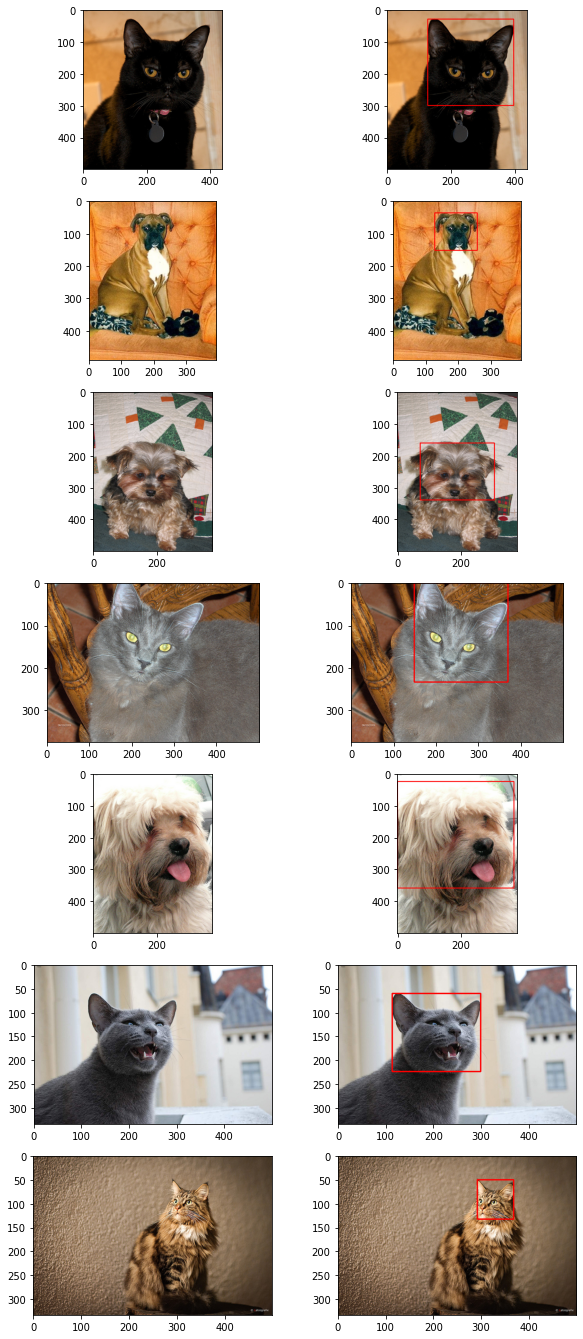

In [ ]:
display_image_grid(dataset_filenames, images_directory)

# Определим класс датасета

Из-за того, что модель предобучена на датасете СOCO __getitem__ должна возвращать:

*   image: PIL изображение размера (H, W)
*   target: словарь, который содержит следующие поля:

      *   boxes (FloatTensor[N, 4]): массив из N координат bbox в [x0, y0, x1, y1] формате
      *   labels (Int64Tensor[N]): метка для каждого bbox. 0 всегда обозначает класс бэкграунда
      *   image_id (Int64Tensor[1]): идентификатор изображения. Он должен быть уникальным для каждого изображения в датасете
      *   area (Tensor[N]): площадь bbox. Используется при валидации модели для подсчета СОСО метрик
      *   iscrowd (UInt8Tensor[N]): объекты с iscrowd = True игнорируются во время валидации
      *   (опционально)  masks (UInt8Tensor[N, H, W]): маска для каждого изображения
      *   (опционально )keypoints (FloatTensor[N, K, 3]): для каждого объекта могут существовать ключевые точки, уточняющие положение объекта 

In [ ]:
class OxfordPetDataset(Dataset):

    def __init__(self, images_filenames, image_dir, transforms=None):
        super().__init__()
        self.image_ids = images_filenames
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        '''ваш код здесь'''
        image_id = self.image_ids[index]
        records = df[df['filename'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)  #reading an image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:,0])  #Calculating area of boxes
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] =  torch.tensor(sample['bboxes']).float()

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_train_transform():
    return A.Compose(
        [
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_test_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
                      

Мы будем использовать 1000 изображений для обучения, 300 изображения для проверки и 100 изображений для тестирования.

In [ ]:
random.seed(42)
random.shuffle(dataset_filenames)

train_images_filenames = dataset_filenames[:1000]
val_images_filenames = dataset_filenames[1000:1300]
test_images_filenames = dataset_filenames[1300:1400]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1000 300 100


Создаем даталоадеры

In [ ]:
!pip freeze | grep albumen

albumentations @ git+https://github.com/albu/albumentations@89a675cbfb2b76f6be90e7049cd5211cb08169a5


In [ ]:
train_dataset = OxfordPetDataset(train_images_filenames, 'dataset/images', get_train_transform())
valid_dataset = OxfordPetDataset(val_images_filenames, 'dataset/images', get_valid_transform())

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Определяем модель

Будем использовать готовую архитектуру Faster-RCNN из torchvision.models

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Определяем количество классов. Их два, потому что нам нужен класс, который будет обозначать бэкграунд

In [ ]:
num_classes = 2  

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Напишем обучение

Определяем параметры для обучения сети

In [ ]:
device = torch.device('cuda')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 2
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Averager - кастомный класс, который считает среднее значение метрик

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def train(train_loader, model, optimizer, epoch):
  loss_hist = Averager()
  itr = 1

  loss_hist.reset()
  
  for images, targets, image_ids in train_loader:
      
     '''ваш код здесь'''
     images = list(image.to(device) for image in images)
     targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
     loss_dict = model(images, targets)
     losses = sum(loss for loss in loss_dict.values())
     loss_value = losses.item()
     loss_hist.send(loss_value)

     optimizer.zero_grad()
     losses.backward()
     optimizer.step()
     
     if itr % 10 == 0:
       print(f"Train iter: {itr} loss: {loss_value}")
     itr += 1
  

  print(f" Train epoch #{epoch} loss: {loss_hist.value}")

In [ ]:
def validate(val_loader, model, epoch):
  loss_hist = Averager()
  itr = 1

  loss_hist.reset()
  with torch.no_grad():
    for images, targets, image_ids in val_loader:
        '''ваш код здесь'''
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)

        if itr % 10 == 0:
          print(f"Validation iter: {itr} loss: {loss_value}")
        itr += 1

    print(f" Validate epoch #{epoch} loss: {loss_hist.value}")

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(train_data_loader, model, optimizer, epoch)
    validate(valid_data_loader, model, epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train iter: 10 loss: 0.2281406968832016
Train iter: 20 loss: 0.20811791718006134
Train iter: 30 loss: 0.20309403538703918
Train iter: 40 loss: 0.1899881511926651
Train iter: 50 loss: 0.17336660623550415
Train iter: 60 loss: 0.12138450145721436
Train iter: 70 loss: 0.13152740895748138
Train iter: 80 loss: 0.12703098356723785
Train iter: 90 loss: 0.11277236044406891
Train iter: 100 loss: 0.09649965912103653
Train iter: 110 loss: 0.1329875886440277
Train iter: 120 loss: 0.08522298187017441
 Train epoch #1 loss: 0.1646864869594574
Validation iter: 10 loss: 0.11420060694217682
Validation iter: 20 loss: 0.12016746401786804
Validation iter: 30 loss: 0.08651567995548248
 Validate epoch #1 loss: 0.10702657483910259
Train iter: 10 loss: 0.10858962684869766
Train iter: 20 loss: 0.11271411180496216
Train iter: 30 loss: 0.11355473846197128
Train iter: 40 loss: 0.09893140941858292
Train iter: 50 loss: 0.12567690014839172
Train iter: 60 loss: 0.09428970515727997
Train iter: 70 loss: 0.102462448179721

# Посмотрим на результаты обучения модели

In [ ]:
test_dataset = OxfordPetDataset(test_images_filenames, 'dataset/images', get_test_transform())

In [ ]:
test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def predict(model, test_data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, targets, image_ids  in  test_data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            outputs = [{k: v.to('cpu') for k, v in t.items()}  for t in outputs]
            outputs = zip(outputs, image_ids)
            for output in outputs:
              predictions.append(output)
    return predictions

In [ ]:
predictions = predict(model, test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Отрисуем результат теста модели

In [ ]:
test_data_loader

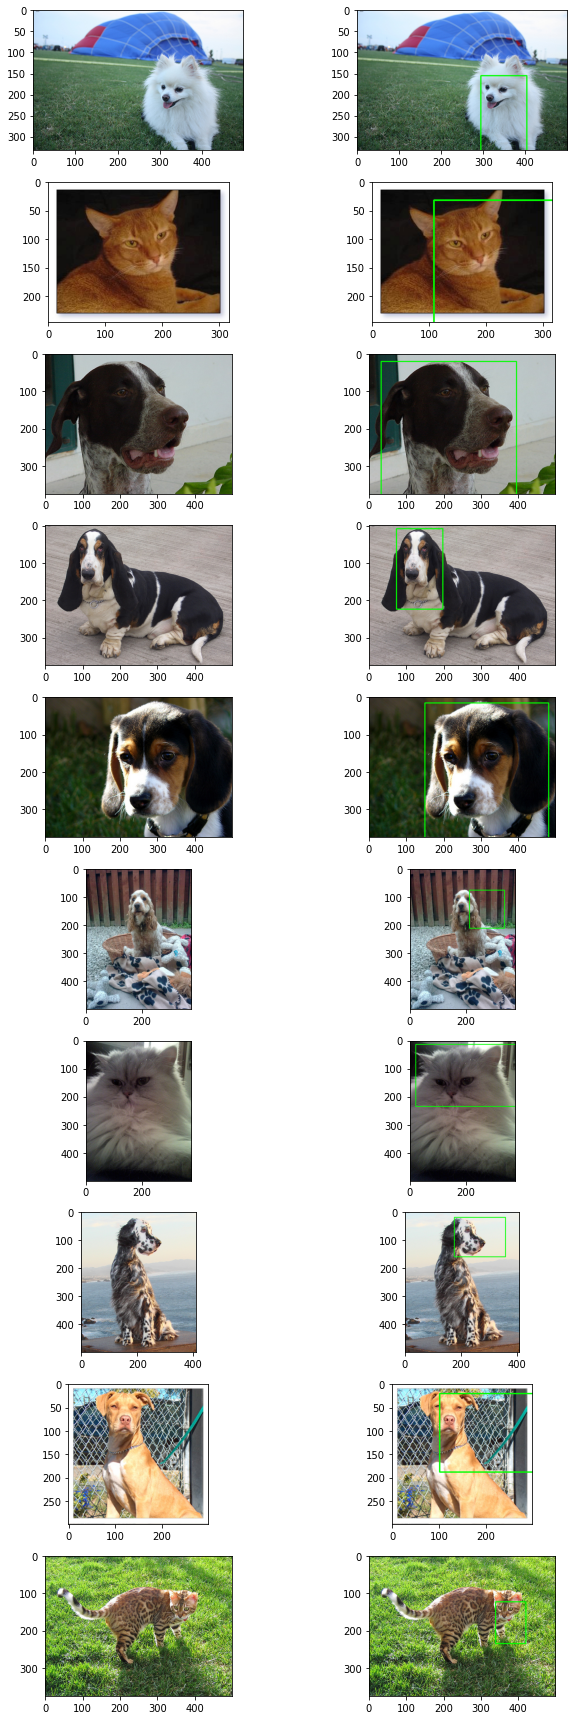

In [ ]:
cols = 2
rows = 10
figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
for i in range(rows):
    prediction = predictions[i]
    '''
    проитерируйтесь по результатам работы сети, вытащите оттуда bbox и отрисуйте их
    '''
    image_path = os.path.join('dataset/images', prediction[1])
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x1, y1, x2, y2 = prediction[0]['boxes'].numpy()[0]
    img_rect = img.copy()
    img_rect = cv2.rectangle(img_rect, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
    ax[i,0].imshow(img)
    ax[i,1].imshow(img_rect)


plt.tight_layout()
plt.show()